In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

In [2]:
vocabulary_size = 20000 # my unique words
sequence_length = 90 # hyperparameter - we take 20 words 

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocabulary_size)



x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=sequence_length)
x_test = preprocessing.sequence.pad_sequences(x_train, maxlen=sequence_length)


split_index = int(0.8 * len(x_train))
imdb_train = tf.data.Dataset.from_tensor_slices(
    (x_train[:split_index], y_train[:split_index])

).cache()

imdb_validate = tf.data.Dataset.from_tensor_slices(
    (x_train[split_index:], y_train[split_index:])

).cache()


imdb_test = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)
).cache()

/Users/iskriyanavasileva/opt/anaconda3/envs/dsr/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/Users/iskriyanavasileva/opt/anaconda3/envs/dsr/lib/python3.6/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
embedding_size = 8 


model = models.Sequential()

#1st feature extraction
model.add(layers.Embedding(
    vocabulary_size,
    embedding_size,
    input_length=sequence_length
))

#2nd feature extraction
model.add(layers.Conv1D(
    250, # kernel size = to extract that many features. We don't know what they are, as they come from something trained
    5, # filter - how many words to look at the same time to extract something; my window size
    padding="valid", # valid - I take only existing points; # same - it will overlap the boarders 
    activation="relu",
    strides=1 # hop length, how much do I move forward
))
model.add(layers.Dropout(0.25))
model.add(layers.GlobalMaxPooling1D()) # global = 1 dimension globally, 1 stride
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation="sigmoid")) # mapping the inputs to the outputs 
                                                #(before that latent space, because we did not have 250 features)


model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"] 
)

history = model.fit(
    imdb_train.shuffle(10000).batch(32), # pipeline; batch - too high - memory will explode and overfitting; too low - slow
    epochs=10,
    validation_data=imdb_validate.batch(32)
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 90, 8)             160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 86, 250)           10250     
_________________________________________________________________
dropout (Dropout)            (None, 86, 250)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 251       
Total params: 170,501
Trainable params: 170,501
Non-trainable params: 0
__________________________________________________

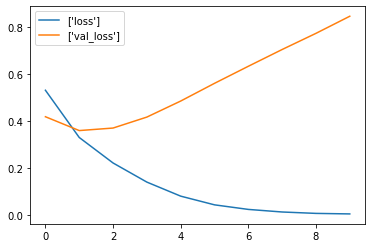

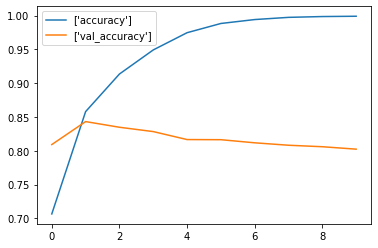

In [4]:
plt.plot(history.history["loss"], label=['loss'])
plt.plot(history.history["val_loss"], label=['val_loss'])
plt.legend()
plt.show()
plt.close()


plt.plot(history.history["accuracy"], label=['accuracy'])
plt.plot(history.history["val_accuracy"], label=['val_accuracy'])
plt.legend()
plt.show()
plt.close()